In [30]:
!pip install tensorflow

In [31]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marcl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
# Load Tweet dataset
df0 = pd.read_csv('./Resources/Bitcoin_tweets.csv')
df0

C:\Users\marcl\AppData\Local\Temp\ipykernel_15960\3715617831.py:2: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv('./Resources/Bitcoin_tweets.csv')


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232804,Angela,"Brighton East, Victoria",Be careful. The devil has a pretty face. 😈 #Bi...,2009-05-21 02:14:09,78.0,1206.0,4802.0,False,2021-09-10 21:15:34,@SpeedUpBSC @debi_pada @AdaTiers @golf_grinder...,"['BTC', 'BSCGems', 'BNB', 'SpeeeUpBSC', 'Airdr...",AngelaAngela,False
1232805,Mike Smith,"London, England",NaN,2021-09-08 21:35:25,0.0,24.0,2.0,False,2021-09-10 21:15:33,"This time, what will happen between the US SEC...","['BTC', 'ETH', 'Coinbase', 'SEC']",Twitter Web App,False
1232806,CryptoMatic 💫,NaN,crypto market analyst 📈📊📉\nDM for business!! 🤝...,2020-07-27 10:02:22,292.0,161.0,14780.0,False,2021-09-10 21:15:04,One #btc is only 205 #EGLD.,"['btc', 'EGLD']",Twitter for Android,False
1232807,OC34N,San Diego,♤♡◇♧\nPatriot\nCreator\njoin new Discord tradi...,2012-08-08 03:25:50,34.0,263.0,826.0,False,2021-09-10 21:14:46,Want to join a group that posted TSLA 745P day...,"['TSLA', 'AMC', 'GME', 'WISH', 'BBIG', 'AMZN',...",Twitter Web App,False


In [61]:

df=df0[['text']][0:20000]
df['date'] = df0['date'][0:20000]

df.set_index('date', inplace=True)

df

,text
date,
2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
2021-02-10 23:54:48,"Guys evening, I have read this article about B..."
2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...
...,...
2021-02-05 22:03:18,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...
2021-02-05 22:03:09,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...
2021-02-05 22:03:07,LINK IN MY BIO!!! \nFlex is dropping officiall...


In [62]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [63]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet_to_words(item)
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 20000/20000 [02:48<00:00, 118.70it/s]


,text,cleantext
date,,
2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,..."
2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl..."
2021-02-10 23:54:48,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh..."
2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ..."
2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi..."
...,...,...
2021-02-05 22:03:18,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...,"[btc, sell, pressur, alert, price, trade, arou..."
2021-02-05 22:03:09,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...,"[husseinchindo, kayodebakre8, wrong, bitcoin, ..."
2021-02-05 22:03:07,LINK IN MY BIO!!! \nFlex is dropping officiall...,"[link, bio, flex, drop, offici, tomorrow, feb,..."


In [64]:
df

,text,cleantext
date,,
2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,..."
2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl..."
2021-02-10 23:54:48,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh..."
2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ..."
2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi..."
...,...,...
2021-02-05 22:03:18,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...,"[btc, sell, pressur, alert, price, trade, arou..."
2021-02-05 22:03:09,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...,"[husseinchindo, kayodebakre8, wrong, bitcoin, ..."
2021-02-05 22:03:07,LINK IN MY BIO!!! \nFlex is dropping officiall...,"[link, bio, flex, drop, offici, tomorrow, feb,..."


In [65]:
# Apply data processing to each tweet
# X = list(map(tweet_to_words, df['content']))
# print(X==cleantext) #True

In [66]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [67]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [83]:
df2 = compute_vader_scores(df, 'cleantext')
df2 = df2.reset_index()

df2


,date,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,...",0.000,0.872,0.128,0.2960,blue ridg bank share halt nyse bitcoin atm ann...,2
1,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl...",0.000,0.775,0.225,0.4939,today thursday take 2 friend leowandersleb btc...,2
2,2021-02-10 23:54:48,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh...",0.000,0.719,0.281,0.5719,guy even read articl btc would like share http...,2
3,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ...",0.000,1.000,0.000,0.0000,btc big chanc billion price 4872644 0 2021 02 ...,1
4,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi...",0.200,0.800,0.000,-0.5423,network secur 9 508 node today soon biggest be...,0
...,...,...,...,...,...,...,...,...,...
19995,2021-02-05 22:03:18,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...,"[btc, sell, pressur, alert, price, trade, arou...",0.000,0.855,0.145,0.2960,btc sell pressur alert price trade around 3782...,2
19996,2021-02-05 22:03:09,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...,"[husseinchindo, kayodebakre8, wrong, bitcoin, ...",0.165,0.638,0.197,-0.1027,husseinchindo kayodebakre8 wrong bitcoin legal...,0
19997,2021-02-05 22:03:07,LINK IN MY BIO!!! \nFlex is dropping officiall...,"[link, bio, flex, drop, offici, tomorrow, feb,...",0.130,0.870,0.000,-0.2732,link bio flex drop offici tomorrow feb 06 2021...,0
19998,2021-02-05 22:02:52,#Bitcoin #Btc\n\nWait and see.... https://t.co...,"[bitcoin, btc, wait, see, http, co, vdaseguhlp]",0.000,1.000,0.000,0.0000,bitcoin btc wait see http co vdaseguhlp,1


In [89]:
# convert the date column to datetime type
df2['date'] = pd.to_datetime(df2['date'])

# group by date and aggregate the values
agg_df = df2.groupby(by=df2['date'].dt.date).agg({'vader_comp': 'mean'})

agg_df



,vader_comp
date,
2021-02-05,0.064975
2021-02-06,0.098810
2021-02-07,0.096075
2021-02-08,0.124207
2021-02-09,0.113830
2021-02-10,0.122121


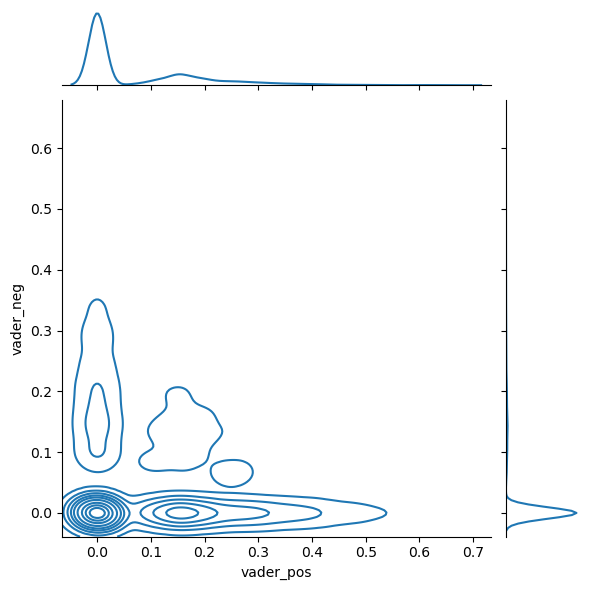

In [86]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

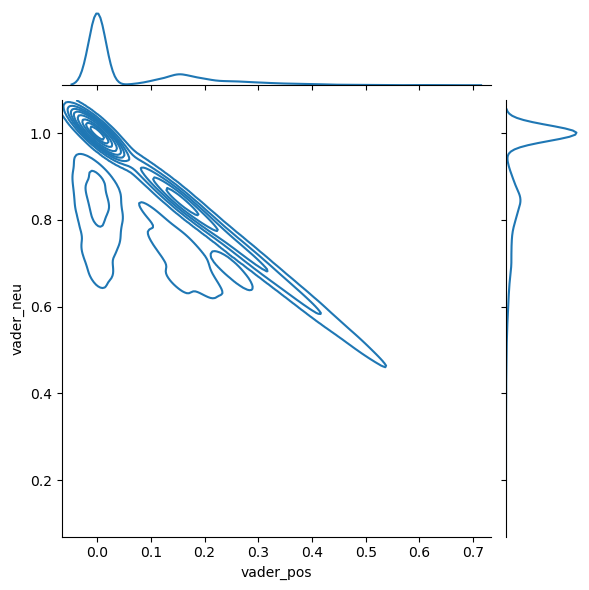

In [87]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neu', kind="kde")

In [88]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0:
        class0+=[0]
    elif df2.loc[i,'vader_pos']>0:
        class0+=[2]        
    else:
        class0+=[1]     

In [81]:
df['class']=class0
df['class'].value_counts()

1    11246
2     6079
0     2675
Name: class, dtype: int64

# def tokenize_pad_sequences(text):

In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 blue ridg bank share halt nyse bitcoin atm announc http co xaazmajkiv myblueridgebank http co sgbxmkp1si 
After Tokenization & Padding 
 [1399 1804  254  406 3652 2760    3 1149  259    2    1    2    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [46]:
print(X.shape)

(20000, 50)


In [47]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (12000, 50) (12000, 3)
Validation Set:  (4000, 50) (4000, 3)
Test Set:  (4000, 50) (4000, 3)


In [48]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses

In [50]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# Model

In [51]:
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

c:\Users\marcl\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [52]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [53]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [54]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/10
188/188 [==============================] - 12s 32ms/step - loss: 0.9583 - accuracy: 0.5623 - precision: 0.5674 - recall: 0.5225 - val_loss: 0.9523 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 2/10
188/188 [==============================] - 4s 21ms/step - loss: 0.9485 - accuracy: 0.5648 - precision: 0.5652 - recall: 0.5633 - val_loss: 0.9454 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 3/10
188/188 [==============================] - 4s 21ms/step - loss: 0.9390 - accuracy: 0.5648 - precision: 0.5692 - recall: 0.5588 - val_loss: 0.9329 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 4/10
188/188 [==============================] - 4s 21ms/step - loss: 0.9191 - accuracy: 0.5659 - precision: 0.5954 - recall: 0.5352 - val_loss: 0.9089 - val_accuracy: 0.5663 - val_precision: 0.6040 - val_recall: 0.5422
Epoch 5/10
188/188 [==============================] - 4s 20ms/step - loss: 0.8860 - accuracy: 0.584

# Evaluate

In [55]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7372
Precision : 0.7907
Recall    : 0.6562
F1 Score  : 0.7172


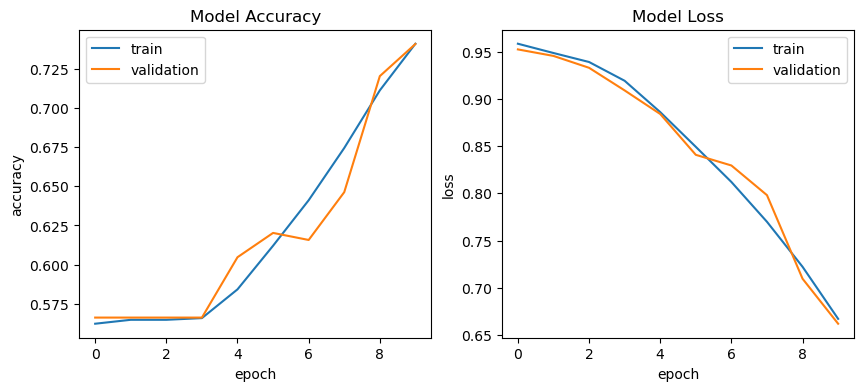

In [56]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

125/125 [==============================] - 2s 5ms/step
1    2203
2    1251
0     546
dtype: int64
1    2489
2    1511
dtype: int64


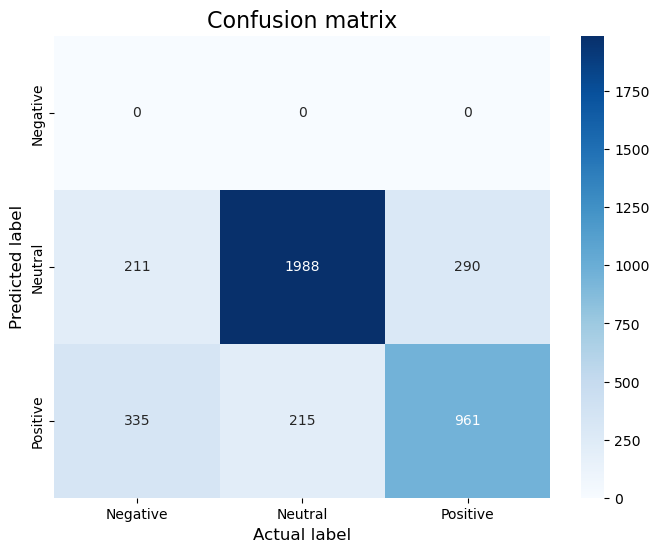

In [57]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)